# Review sentiment classification using BOW and Tf-idf models and morphological analysis

This notebook analyse hotel reviews from booking.com. We use various models to test their accuracy in prediction of review sentiment (positive or negative review)

In [1]:
from pdf2image import convert_from_path
import easyocr
import PIL
from PIL import ImageDraw
import numpy as np
import spacy

from spacy import displacy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, log_loss

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords

nltk.download('wordnet')

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

tf.get_logger().setLevel('ERROR')

[nltk_data] Downloading package wordnet to /Users/israel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# import the data
reviews_data = pd.read_csv('/Users/israel/Downloads/Hotel_Reviews_Booking.csv')
#reviews_data = reviews_data[:1000]
reviews_data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## EDA

##### Present the top 10 nations reviewers are coming from

In [4]:
temp = reviews_data.groupby('Reviewer_Nationality').count()['Reviewer_Score'].reset_index().sort_values(by='Reviewer_Score',ascending=False)
temp[:10].style.background_gradient(cmap='Purples')

,Reviewer_Nationality,Reviewer_Score
66,United Kingdom,475
68,United States of America,87
25,Ireland,57
2,Australia,39
7,Canada,26
40,Netherlands,21
16,Germany,18
28,Italy,17
15,France,17
27,Israel,16


In [5]:
# Coint the length of positive and vegative reviews
reviews_data['Num_words_pos'] = reviews_data['Positive_Review'].apply(lambda x:len(str(x).split()))
reviews_data['Num_words_neg'] = reviews_data['Negative_Review'].apply(lambda x:len(str(x).split()))
reviews_data['Num_words_pos_neg_diff'] = reviews_data['Num_words_pos'] - reviews_data['Num_words_neg']

#### Histogram of reviews length by positive and negative labels

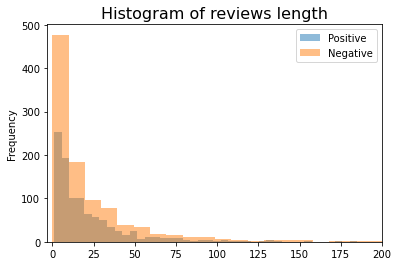

In [6]:
reviews_data['Num_words_pos'].plot.hist(bins=40, alpha=0.5, label='Positive').set_xlim(-3, 200)
reviews_data['Num_words_neg'].plot.hist(bins=40, alpha=0.5, label='Negative')
plt.title('Histogram of reviews length', fontsize=16)
plt.legend()
plt.show()

#### Differences in length

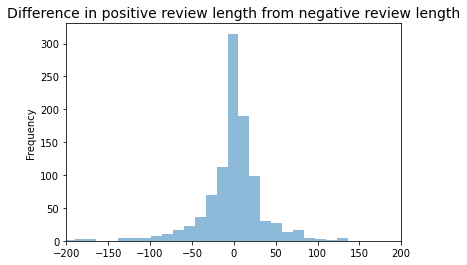

In [7]:
reviews_data['Num_words_pos_neg_diff'].plot.hist(bins=40, alpha=0.5).set_xlim(-200, 200)
plt.title('Difference in positive review length from negative review length', fontsize=14)
plt.show()

#### Named Entity Recognition

In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
# Let’s have a look in a positive review for example
text = reviews_data['Positive_Review'][10]
text

' Rooms were stunningly decorated and really spacious in the top of the building Pictures are of room 300 The true beauty of the building has been kept but modernised brilliantly Also the bath was lovely and big and inviting Great more for couples Restaurant menu was a bit pricey but there were loads of little eatery places nearby within walking distance and the tram stop into the centre was about a 6 minute walk away and only about 3 or 4 stops from the centre of Amsterdam Would recommend this hotel to anyone it s unbelievably well priced too '

In [10]:
doc = nlp(text)
displacy.render(nlp(doc.text),style='ent', jupyter=True)

In [11]:
# Let’s have a look in a positive review for example
text = reviews_data['Negative_Review'][3]
text

' My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked like it was attacked by an angry dog My shower drain was clogged and the staff did not respond to my request to clean it On a day with heavy rainfall a pretty common occurrence in Amsterdam the roof in my room was leaking luckily not on the bed you could also see signs of earlier water damage I also saw insects running on the floor Overall the second floor of the property looked dirty and badly kept On top of all of this a repairman who came to fix something in a room next door at midnight was very noisy as were many of the guests I understand the challenges of running a hotel in an old building but this negligence is inconsistent with prices demanded by the hotel On the last night after I complained about water damage the night shift manager offered to move me to a different room but that offer

In [12]:
doc = nlp(text)
displacy.render(nlp(doc.text),style='ent', jupyter=True)

##### POS tagging

In [13]:
pos_df = pd.DataFrame(columns = ['text','pos', 'tag', 'dep','shape', 'is_alpha', 'is_stop', 'lemma'])
for token in doc:
    pos_df.loc[len(pos_df)] = [token.text, token.pos_, token.tag_, token.dep_,token.shape_, token.is_alpha, token.is_stop, token.lemma_]
pos_df

,text,pos,tag,dep,shape,is_alpha,is_stop,lemma
0,,SPACE,_SP,dep,,False,False,
1,My,PRON,PRP$,poss,Xx,True,True,my
2,room,NOUN,NN,nsubj,xxxx,True,False,room
3,was,AUX,VBD,ROOT,xxx,True,True,be
4,dirty,ADJ,JJ,acomp,xxxx,True,False,dirty
...,...,...,...,...,...,...,...,...
204,bed,NOUN,NN,pobj,xxx,True,False,bed
205,and,CCONJ,CC,cc,xxx,True,True,and
206,ready,ADJ,JJ,conj,xxxx,True,False,ready
207,to,PART,TO,aux,xx,True,True,to


#### Remove stop words

In [14]:
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [15]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [16]:
reviews_data['Positive_Review_rsw'] = reviews_data['Positive_Review'].apply(stopwords)
reviews_data['Negative_Review_rsw'] = reviews_data['Negative_Review'].apply(stopwords)
reviews_data.head(5)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,Reviewer_Score,Tags,days_since_review,lat,lng,Num_words_pos,Num_words_neg,Num_words_pos_neg_diff,Positive_Review_rsw,Negative_Review_rsw
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,...,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,9,395,-386,park outside hotel beautiful,angry made post available via possible sites u...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,...,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,103,2,101,real complaints hotel great great location sur...,negative
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,...,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,19,40,-21,location good staff ok cute hotel breakfast ra...,rooms nice elderly bit difficult rooms two sto...
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,...,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,24,208,-184,great location nice surroundings bar restauran...,room dirty afraid walk barefoot floor looked c...
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,...,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,6,138,-132,amazing location building romantic setting,booked company line showed pictures room thoug...


### Word clouds for good and bad reviews

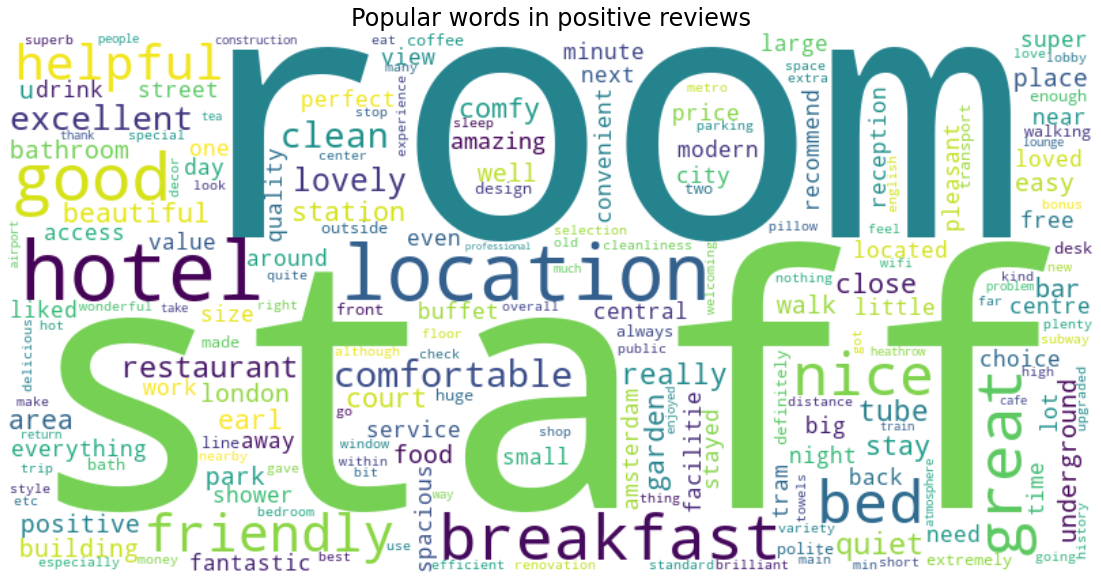

In [17]:
# Creating the text variable
text = " ".join(cat for cat in reviews_data.Positive_Review_rsw)

# Creating word_cloud
word_cloud = WordCloud(collocations = False, background_color = 'white', width=800, height=400).generate(text)

# Display the generated Word Cloud
plt.figure( figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Popular words in positive reviews', fontsize=24)
plt.axis("off")
plt.show()

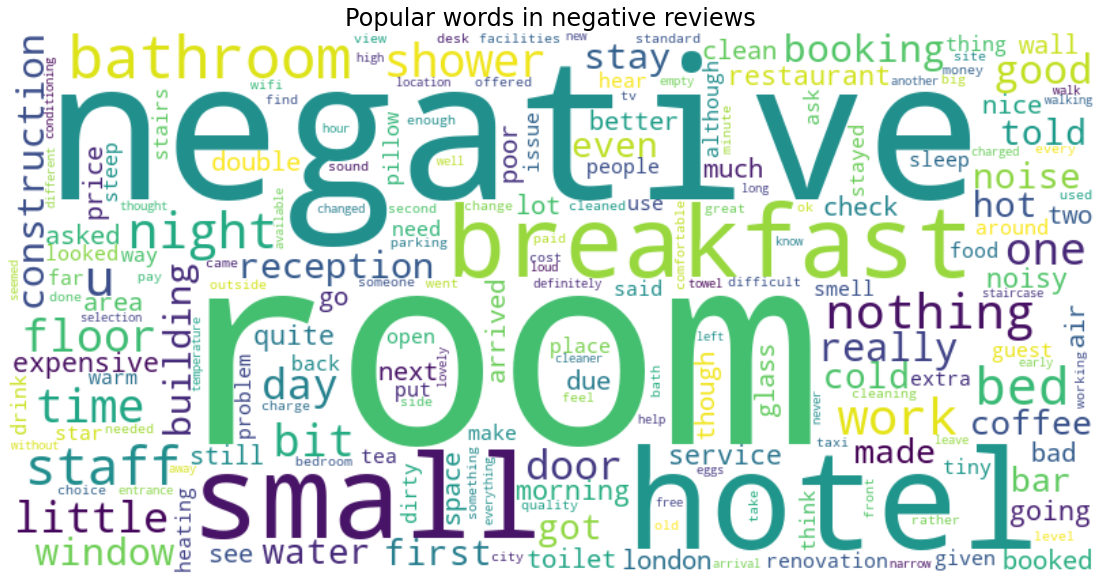

In [18]:
# Creating the text variable
text = " ".join(cat for cat in reviews_data.Negative_Review_rsw)

# Creating word_cloud
word_cloud = WordCloud(collocations = False, background_color = 'white', width=800, height=400).generate(text)

# Display the generated Word Cloud
plt.figure( figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Popular words in negative reviews', fontsize=24)
plt.axis("off")
plt.show()

We see the differences between positive to negative reviews. As both of them mention the 'room' and the 'hotel'. As expected the positive reviews mention positive words like 'good', 'great', 'nice', 'lovely'. The negative reviews mention negative reviews like 'small', 'little', 'noise'.

### Data preparation

In [19]:
### Data preparation
pos_df = reviews_data[['Positive_Review_rsw']]
pos_df.columns = ['Review']
pos_df['Positive'] = 1

neg_df = reviews_data[['Negative_Review_rsw']]
neg_df.columns = ['Review']
neg_df['Positive'] = 0

clf_df = pd.concat([pos_df,neg_df])
clf_df = clf_df.drop_duplicates().reset_index(drop=True)
clf_df

,Review,Positive
0,park outside hotel beautiful,1
1,real complaints hotel great great location sur...,1
2,location good staff ok cute hotel breakfast ra...,1
3,great location nice surroundings bar restauran...,1
4,amazing location building romantic setting,1
...,...,...
1623,seating bar area would good also trek use toilets,0
1624,cleaner knocked door 8am ideal checking day ne...,0
1625,second time hotel first time booked basic room...,0
1626,going family two rooms hired reservation alloc...,0


In [20]:
clf_df['Positive'].value_counts()

1    919
0    709
Name: Positive, dtype: int64

### Stemming and lemmatising

In [21]:
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

#tokenization
clf_df['review_token'] = clf_df['Review'].apply(lambda tok: word_tokenize(tok.lower()))
#lemmatizing 
clf_df['lemma_review_token'] = clf_df['review_token'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
#stemming
clf_df['stem_review_token'] = clf_df['review_token'].apply(lambda x: [porter.stem(y) for y in x])
# join to sentences
clf_df['Review_lemmatized'] = clf_df['lemma_review_token'].apply(lambda series: ' '.join([word for word in series]))
clf_df['Review_stemmed'] = clf_df['stem_review_token'].apply(lambda series: ' '.join([word for word in series]))
clf_df = clf_df[['Review','Review_lemmatized','Review_stemmed','Positive']]
clf_df

,Review,Review_lemmatized,Review_stemmed,Positive
0,park outside hotel beautiful,park outside hotel beautiful,park outsid hotel beauti,1
1,real complaints hotel great great location sur...,real complaint hotel great great location surr...,real complaint hotel great great locat surroun...,1
2,location good staff ok cute hotel breakfast ra...,location good staff ok cute hotel breakfast ra...,locat good staff ok cute hotel breakfast rang ...,1
3,great location nice surroundings bar restauran...,great location nice surroundings bar restauran...,great locat nice surround bar restaur nice lov...,1
4,amazing location building romantic setting,amazing location building romantic setting,amaz locat build romant set,1
...,...,...,...,...
1623,seating bar area would good also trek use toilets,seating bar area would good also trek use toilet,seat bar area would good also trek use toilet,0
1624,cleaner knocked door 8am ideal checking day ne...,cleaner knocked door 8am ideal checking day ne...,cleaner knock door 8am ideal check day need cl...,0
1625,second time hotel first time booked basic room...,second time hotel first time booked basic room...,second time hotel first time book basic room p...,0
1626,going family two rooms hired reservation alloc...,going family two room hired reservation alloca...,go famili two room hire reserv alloc us two di...,0


#### Create BOW matrix

In [22]:
# extract the tfid representation matrix of the text data (remove numbers)
bow_vectorizer = CountVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
bow_matrix = bow_vectorizer.fit_transform(clf_df['Review'])
# collect the bow matrix in dataframe
bow_df = pd.DataFrame(bow_matrix.todense(), columns= bow_vectorizer.get_feature_names_out())
bow_df

,00pm,10mins,12nn,12pm,15min,15pounds,16th,18th,1990s,1am,...,yes,yesterday,yet,yogurt,young,yrt,z,zero,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# BOW for lemmatized and lemmatized text
bow_vectorizer = CountVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
bow_matrix = bow_vectorizer.fit_transform(clf_df['Review_lemmatized'])
lemmatized_bow_df = pd.DataFrame(bow_matrix.todense(), columns= bow_vectorizer.get_feature_names_out())

# BOW for lemmatized and stemmed text
bow_vectorizer = CountVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
bow_matrix = bow_vectorizer.fit_transform(clf_df['Review_stemmed'])
stemmed_bow_df = pd.DataFrame(bow_matrix.todense(), columns= bow_vectorizer.get_feature_names_out())

#### Create Tf-idf matrix

In [24]:
# extract the tfid representation matrix of the text data (remove numbers)
tf_idf_vectorizer = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(clf_df['Review'])
# collect the tfid matrix in dataframe
tf_idf_df = pd.DataFrame(tf_idf_matrix.todense(), columns= tf_idf_vectorizer.get_feature_names_out())
tf_idf_df

,00pm,10mins,12nn,12pm,15min,15pounds,16th,18th,1990s,1am,...,yes,yesterday,yet,yogurt,young,yrt,z,zero,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# tfid for lemmatized and lemmatized text
tf_idf_vectorizer = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(clf_df['Review_lemmatized'])
lemmatized_tf_idf_df = pd.DataFrame(tf_idf_matrix.todense(), columns= tf_idf_vectorizer.get_feature_names_out())

# tfid for lemmatized and stemmed text
tf_idf_vectorizer = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(clf_df['Review_stemmed'])
stemmed_tf_idf_df = pd.DataFrame(tf_idf_matrix.todense(), columns= tf_idf_vectorizer.get_feature_names_out())

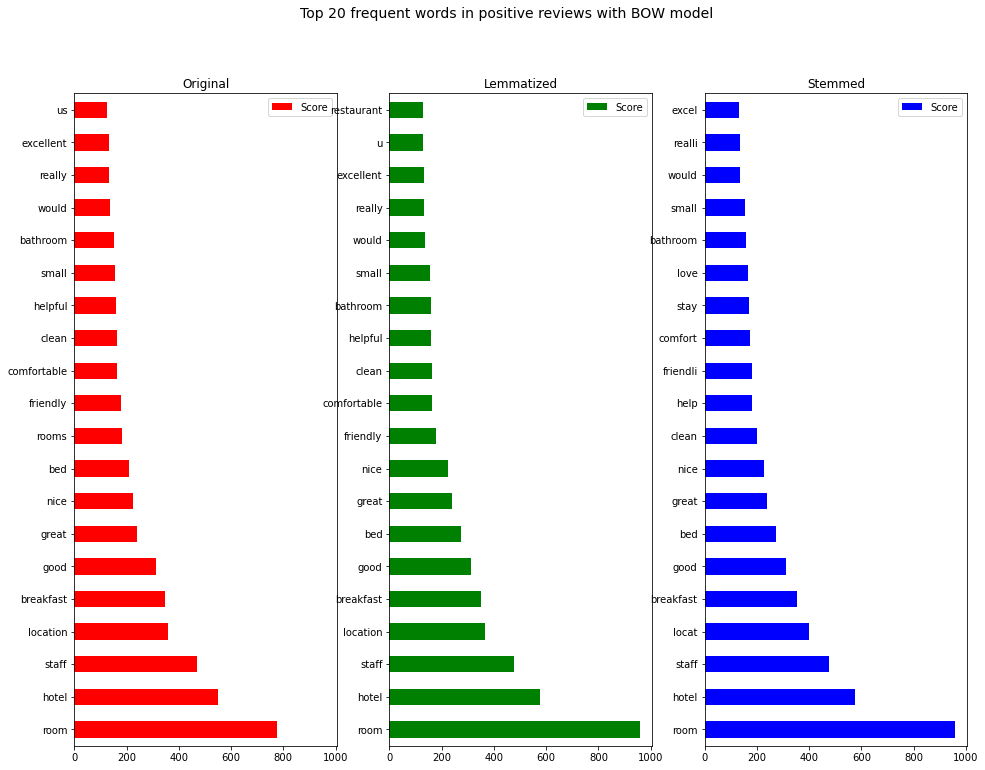

In [26]:
## Show the most important words with BOW for positive reviews
top_vocab_bow = pd.DataFrame(bow_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)
top_lemma_vocab_bow = pd.DataFrame(lemmatized_bow_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)
top_stem_vocab_bow = pd.DataFrame(stemmed_bow_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)


fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, sharex=True, sharey=False, figsize=(16, 12), frameon=False
)
fig.suptitle("Top 20 frequent words in positive reviews with BOW model", fontsize=14)

top_vocab_bow[:20].plot.barh(ax=ax1, color=['red'])
top_lemma_vocab_bow[:20].plot.barh(ax=ax2, color=['green'])
top_stem_vocab_bow[:20].plot.barh(ax=ax3, color=['blue'])
ax1.title.set_text('Original')
ax2.title.set_text('Lemmatized')
ax3.title.set_text('Stemmed')

plt.show()

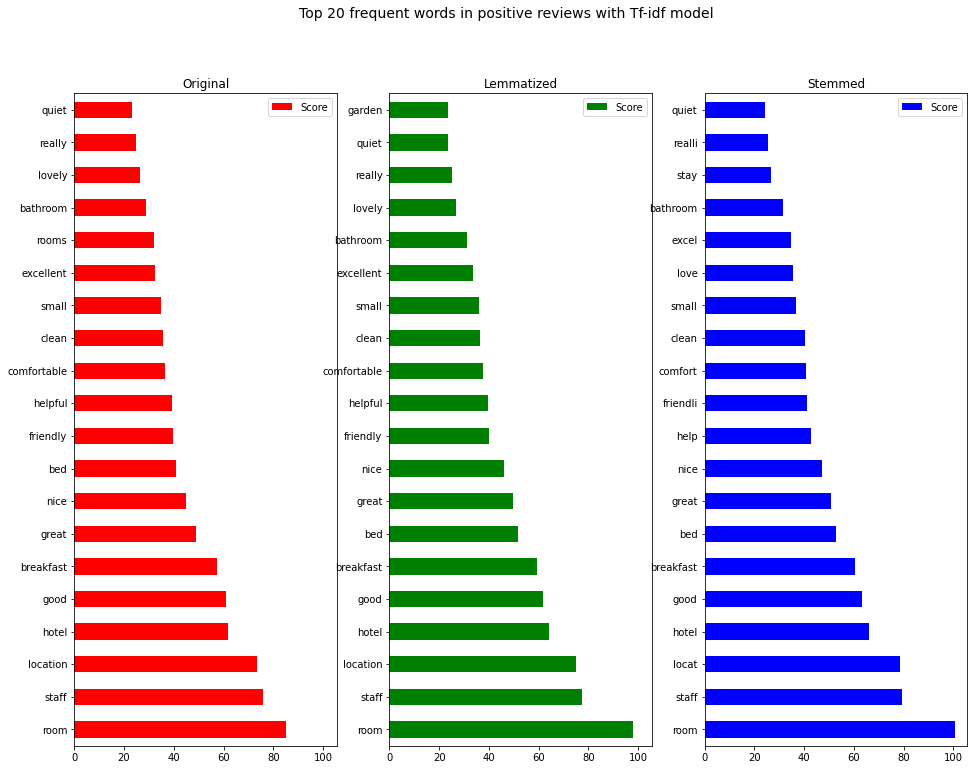

In [27]:
## Show the most important words with BOW for positive reviews
top_vocab_tfidf = pd.DataFrame(tf_idf_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)
top_lemma_vocab_tfidf = pd.DataFrame(lemmatized_tf_idf_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)
top_stem_vocab_tfidf = pd.DataFrame(stemmed_tf_idf_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)


fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, sharex=True, sharey=False, figsize=(16, 12), frameon=False
)
fig.suptitle("Top 20 frequent words in positive reviews with Tf-idf model", fontsize=14)

top_vocab_tfidf[:20].plot.barh(ax=ax1, color=['red'])
top_lemma_vocab_tfidf[:20].plot.barh(ax=ax2, color=['green'])
top_stem_vocab_tfidf[:20].plot.barh(ax=ax3, color=['blue'])
ax1.title.set_text('Original')
ax2.title.set_text('Lemmatized')
ax3.title.set_text('Stemmed')

plt.show()

In [28]:
# train - test split
# assign test data size 25%

##### BOW #####
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)
X_train_lemma_bow, X_test_lemma_bow, y_train_lemma_bow, y_test_lemma_bow = train_test_split(lemmatized_bow_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)
X_train_stem_bow, X_test_stem_bow, y_train_stem_bow, y_test_stem_bow = train_test_split(stemmed_bow_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)

##### Tf-idf #####
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(bow_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)
X_train_lemma_tfidf, X_test_lemma_tfidf, y_train_lemma_tfidf, y_test_lemma_tfidf = train_test_split(lemmatized_tf_idf_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)
X_train_stem_tfidf, X_test_stem_tfidf, y_train_stem_tfidf, y_test_stem_tfidf = train_test_split(stemmed_tf_idf_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)

### Training model

In [29]:
def model_training(parameter_grid, classifier, X_train, y_train, X_test, y_test):
    
    # gridsearch object using 5 fold cross validation and neg_log_loss as scoring paramter
    gridsearch = GridSearchCV(classifier,parameter_grid, scoring = 'neg_log_loss', cv = 5)
    # fit the gridsearch
    gridsearch.fit(X_train, y_train)
    
    print("Best parameter: ",gridsearch.best_params_)
    # prediction accuracy of the train data
    y_pred = gridsearch.predict(X_test)
    y_pred_proba = gridsearch.predict_proba(X_test)[::,1]
    
    print('Accuracy of best estimator for the test data: ',accuracy_score(y_test, y_pred))
    return y_pred, y_pred_proba, gridsearch.cv_results_

In [30]:
# track model performance
log_models = pd.DataFrame(columns=["Classifier","morphological analysis","Model","Accuracy","AUC"])

#### Multinomial NB

In [31]:
# parameter grid
parameter_grid = [{"alpha": np.linspace(0.001, 10, 100)}]

##### BOW model

Original text: 
Best parameter:  {'alpha': 3.233}
Accuracy of best estimator for the test data:  0.8918918918918919

 Lemmatized text: 
Best parameter:  {'alpha': 3.132}
Accuracy of best estimator for the test data:  0.8918918918918919

 Stemmed text: 
Best parameter:  {'alpha': 3.637}
Accuracy of best estimator for the test data:  0.8968058968058968


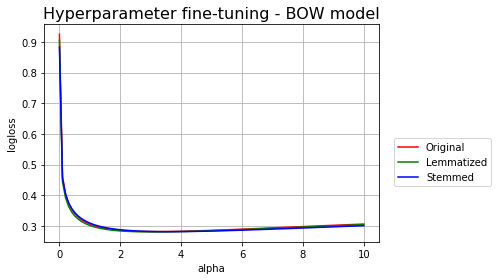

In [32]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, MultinomialNB(), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, MultinomialNB(), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, MultinomialNB(), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_alpha'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_alpha'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_alpha'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'alpha': 3.233}
Accuracy of best estimator for the test data:  0.8918918918918919

 Lemmatized text: 
Best parameter:  {'alpha': 0.10200000000000001}
Accuracy of best estimator for the test data:  0.8943488943488943

 Stemmed text: 
Best parameter:  {'alpha': 0.10200000000000001}
Accuracy of best estimator for the test data:  0.8894348894348895


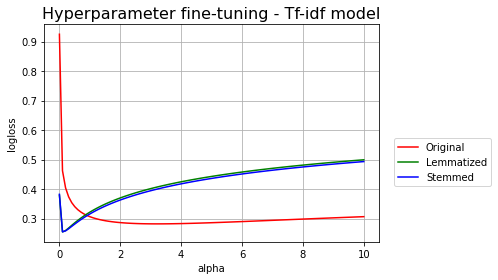

In [33]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, MultinomialNB(), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, MultinomialNB(), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, MultinomialNB(), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_alpha'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_alpha'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_alpha'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

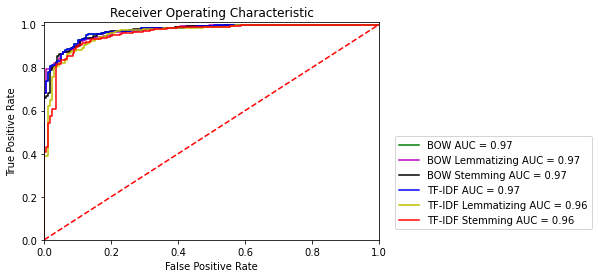

In [34]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
log_models.loc[len(log_models)] = ['Multinomial NB','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['Multinomial NB','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['Multinomial NB','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['Multinomial NB','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['Multinomial NB','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['Multinomial NB','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

#### Bernoulli NB

In [36]:
# parameter grid
parameter_grid = [{"alpha": np.linspace(0.001, 10, 100)}]

##### BOW model

Original text: 
Best parameter:  {'alpha': 0.30400000000000005}
Accuracy of best estimator for the test data:  0.8402948402948403

 Lemmatized text: 
Best parameter:  {'alpha': 0.30400000000000005}
Accuracy of best estimator for the test data:  0.8452088452088452

 Stemmed text: 
Best parameter:  {'alpha': 0.405}
Accuracy of best estimator for the test data:  0.8476658476658476


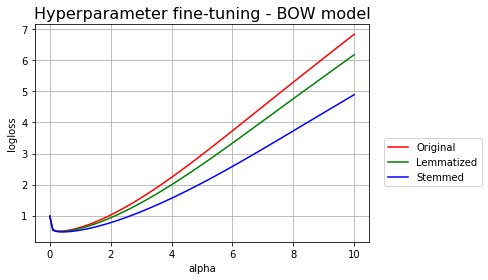

In [37]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, BernoulliNB(), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, BernoulliNB(), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, BernoulliNB(), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_alpha'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_alpha'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_alpha'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'alpha': 0.30400000000000005}
Accuracy of best estimator for the test data:  0.8402948402948403

 Lemmatized text: 
Best parameter:  {'alpha': 0.30400000000000005}
Accuracy of best estimator for the test data:  0.8452088452088452

 Stemmed text: 
Best parameter:  {'alpha': 0.405}
Accuracy of best estimator for the test data:  0.8476658476658476


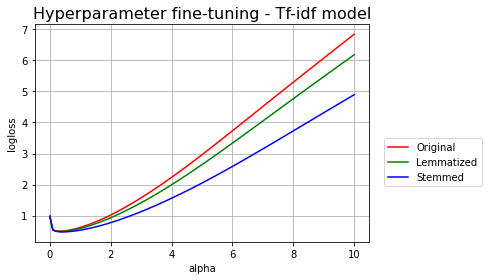

In [38]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, BernoulliNB(), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, BernoulliNB(), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, BernoulliNB(), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_alpha'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_alpha'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_alpha'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

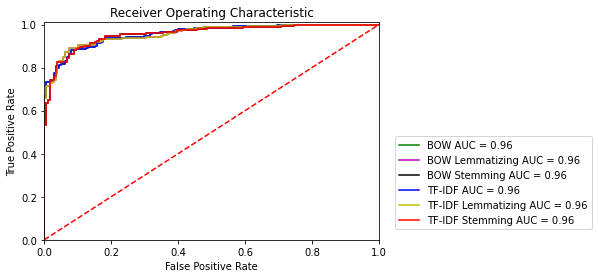

In [39]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
log_models.loc[len(log_models)] = ['Bernoulli NB','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['Bernoulli NB','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['Bernoulli NB','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['Bernoulli NB','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['Bernoulli NB','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['Bernoulli NB','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

Bernoulli NB assumes that all the features are binary such that they take only two values: 0 represent that word does not occur in the text and 1 as word occurs in the text. Where as Multinomial NB cares about counts for multiple features that do occur and it is use with the count of each word to predict the label.

For this reasons we see that the multinomial NB works better with our data.

#### SVM

In [41]:
# parameter grid
parameter_grid = [{'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}]

##### BOW model

Original text: 
Best parameter:  {'gamma': 0.01, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.8771498771498771

 Lemmatized text: 
Best parameter:  {'gamma': 0.01, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.8796068796068796

 Stemmed text: 
Best parameter:  {'gamma': 0.01, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.8943488943488943


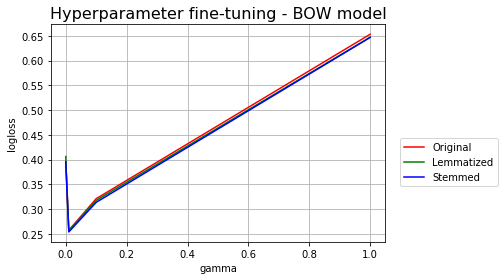

In [42]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, SVC(probability=True), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, SVC(probability=True), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, SVC(probability=True), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_gamma'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_gamma'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_gamma'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('gamma')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'gamma': 0.01, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.8771498771498771

 Lemmatized text: 
Best parameter:  {'gamma': 0.1, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.9017199017199017

 Stemmed text: 
Best parameter:  {'gamma': 1, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.9213759213759214


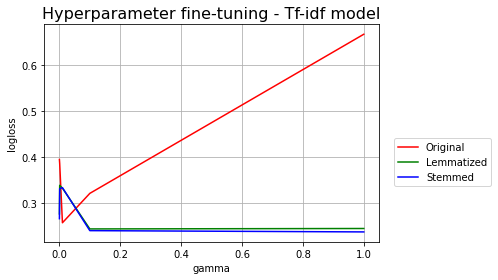

In [43]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, SVC(probability=True), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, SVC(probability=True), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, SVC(probability=True), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_gamma'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_gamma'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_gamma'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('gamma')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

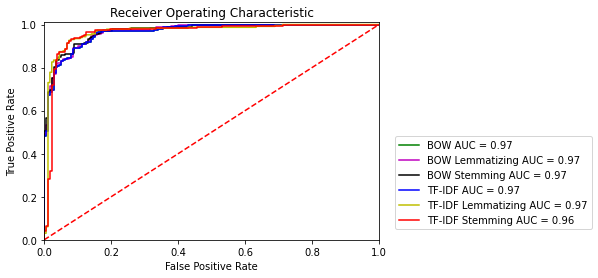

In [44]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:
log_models.loc[len(log_models)] = ['SVM','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['SVM','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['SVM','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['SVM','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['SVM','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['SVM','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

#### Decision Tree Classifier

In [46]:
# parameter grid
parameter_grid = [{'max_depth':[2,3,4,5,6,7,8,9,10,11,12,15,20]}]

##### BOW model

Original text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7493857493857494

 Lemmatized text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7493857493857494

 Stemmed text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7518427518427518


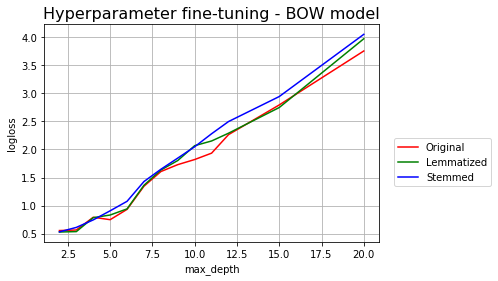

In [47]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, DecisionTreeClassifier(), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, DecisionTreeClassifier(), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, DecisionTreeClassifier(), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_max_depth'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_max_depth'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_max_depth'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('max_depth')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'max_depth': 3}
Accuracy of best estimator for the test data:  0.7862407862407862

 Lemmatized text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7567567567567568

 Stemmed text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7567567567567568


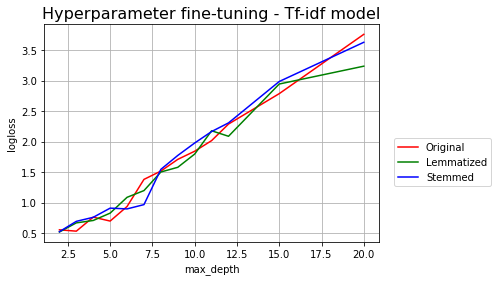

In [48]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, DecisionTreeClassifier(), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, DecisionTreeClassifier(), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, DecisionTreeClassifier(), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_max_depth'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_max_depth'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_max_depth'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('max_depth')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

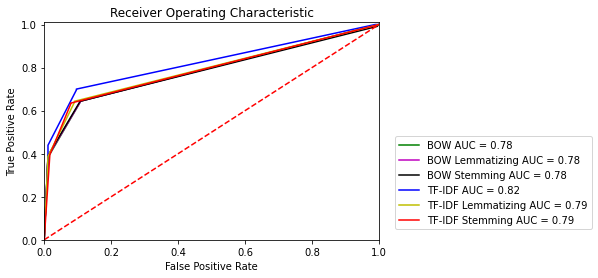

In [49]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

#### K-Neighbors Classifier

In [51]:
# parameter grid
parameter_grid = [{'n_neighbors':list(range(1, 21))}]

##### BOW model

Original text: 
Best parameter:  {'n_neighbors': 14}
Accuracy of best estimator for the test data:  0.8083538083538083

 Lemmatized text: 
Best parameter:  {'n_neighbors': 16}
Accuracy of best estimator for the test data:  0.8329238329238329

 Stemmed text: 
Best parameter:  {'n_neighbors': 20}
Accuracy of best estimator for the test data:  0.828009828009828


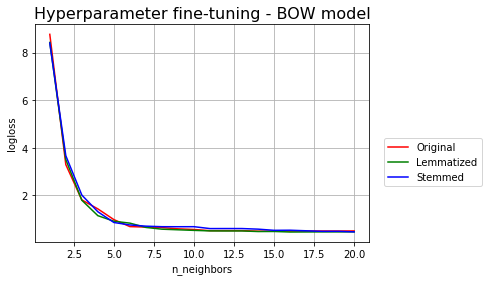

In [52]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, KNeighborsClassifier(), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, KNeighborsClassifier(), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, KNeighborsClassifier(), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_n_neighbors'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_n_neighbors'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_n_neighbors'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('n_neighbors')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'n_neighbors': 14}
Accuracy of best estimator for the test data:  0.8083538083538083

 Lemmatized text: 
Best parameter:  {'n_neighbors': 18}
Accuracy of best estimator for the test data:  0.8746928746928747

 Stemmed text: 
Best parameter:  {'n_neighbors': 19}
Accuracy of best estimator for the test data:  0.8722358722358723


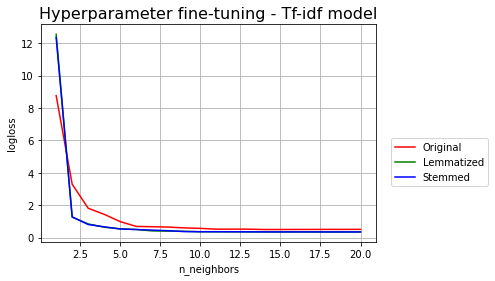

In [53]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, KNeighborsClassifier(), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, KNeighborsClassifier(), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, KNeighborsClassifier(), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_n_neighbors'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_n_neighbors'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_n_neighbors'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('n_neighbors')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

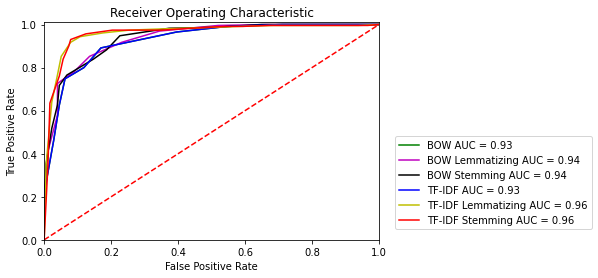

In [54]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

#### ANN

In [56]:
# parameter grid
#parameter_grid = [{'batch_size':[10, 20, 40, 60, 80, 100], 'epochs':[1,3,5,10, 30, 50]}]
parameter_grid = [{'batch_size':[10, 20, 40, 60, 80, 100]}]

In [57]:
def ANNModel(n_features):
    # create model
    model = Sequential()
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(12, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

##### BOW model

Original text: 


2022-09-13 16:48:03.156819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8820638820638821

 Lemmatized text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8894348894348895

 Stemmed text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8894348894348895


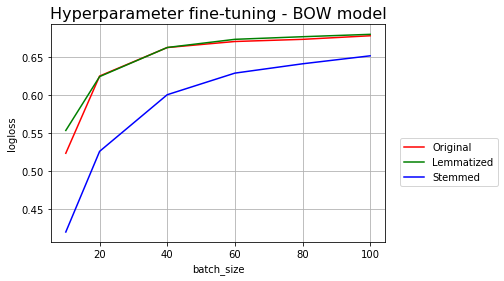

In [58]:
print('Original text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_bow.shape[1]), verbose=0)
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, ANNClassifier, X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_lemma_bow.shape[1]), verbose=0)
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, ANNClassifier, X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_stem_bow.shape[1]), verbose=0)
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, ANNClassifier, X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_batch_size'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_batch_size'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_batch_size'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('batch_size')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8845208845208845

 Lemmatized text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8722358722358723

 Stemmed text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.683046683046683


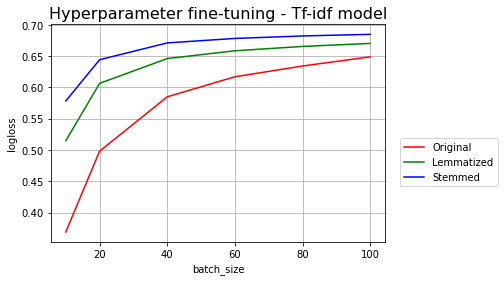

In [59]:
print('Original text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_tfidf.shape[1]), verbose=0)
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, ANNClassifier, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_lemma_tfidf.shape[1]), verbose=0)
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, ANNClassifier, X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_stem_tfidf.shape[1]), verbose=0)
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, ANNClassifier, X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_batch_size'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_batch_size'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_batch_size'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('batch_size')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

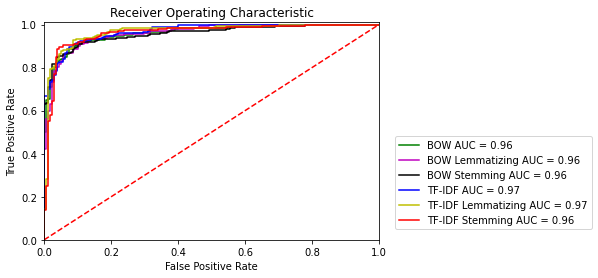

In [60]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
log_models.loc[len(log_models)] = ['ANN','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['ANN','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['ANN','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['ANN','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['ANN','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['ANN','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

### Model selection

In [62]:
# Present accuracy and AUC of all the models
log_models.sort_values(by="Accuracy",ascending=False)

,Classifier,morphological analysis,Model,Accuracy,AUC
17,SVM,Stemming,TF-IDF,0.921376,0.960255
16,SVM,Lemmatizing,TF-IDF,0.901720,0.966200
2,Multinomial NB,Stemming,BOW,0.896806,0.970671
14,SVM,Stemming,BOW,0.894349,0.968976
4,Multinomial NB,Lemmatizing,TF-IDF,0.894349,0.959789
1,Multinomial NB,Lemmatizing,BOW,0.891892,0.970818
0,Multinomial NB,Original,BOW,0.891892,0.972341
3,Multinomial NB,Original,TF-IDF,0.891892,0.972341
32,ANN,Stemming,BOW,0.889435,0.957087
31,ANN,Lemmatizing,BOW,0.889435,0.959519


In [63]:
log_models.sort_values(by="AUC",ascending=False)

,Classifier,morphological analysis,Model,Accuracy,AUC
0,Multinomial NB,Original,BOW,0.891892,0.972341
3,Multinomial NB,Original,TF-IDF,0.891892,0.972341
1,Multinomial NB,Lemmatizing,BOW,0.891892,0.970818
2,Multinomial NB,Stemming,BOW,0.896806,0.970671
14,SVM,Stemming,BOW,0.894349,0.968976
13,SVM,Lemmatizing,BOW,0.879607,0.967526
33,ANN,Original,TF-IDF,0.884521,0.967060
16,SVM,Lemmatizing,TF-IDF,0.901720,0.966200
34,ANN,Lemmatizing,TF-IDF,0.872236,0.965954
12,SVM,Original,BOW,0.877150,0.965340


We see that Multinomial NB and SVM models works better with data. USing BOW or Tf-idf doesn't change significantly the accuracy. We also do not see significant better performance with stemming or lemmatizing analysis.